# Seminární práce z předmětu Počítačové zpracování signálu (KI/PZS)
**Téma:** 1. Výpočet tepové frekvence z EKG signálu

**Autor:** Karel Murgač

## Zadání
Cílem této části je navrhnout algoritmus pro automatickou detekci R-vrcholů v EKG signálu a výpočet tepové frekvence.
Algoritmus bude aplikován na databázi **DriveDB** (monitoring řidičů) a následně validován na databázi **MIT-BIH (NSRDB)**.

**Postup řešení:**
1. Načtení dat pomocí knihovny `wfdb`.
2. Detekce R-vrcholů (dominantních peaků) v signálu.
3. Výpočet tepové frekvence (BPM).
4. Vizualizace výsledků a zhodnocení úspěšnosti.

In [1]:
# !pip install wfdb scipy matplotlib numpy

import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

# Nastavení grafů pro lepší čitelnost
plt.rcParams['figure.figsize'] = [15, 5]
print("Knihovny úspěšně načteny.")

Knihovny úspěšně načteny.


## 1. Návrh algoritmu pro detekci R-vrcholů

[cite_start]Podle zadání [cite: 29] určuje vzdálenost R-vrcholů dobu mezi tepy. Tepová frekvence (Heart Rate - HR) se vypočítá jako počet těchto vrcholů za minutu.

Můj algoritmus využívá funkci `find_peaks` z knihovny `scipy`, která hledá lokální maxima. Abychom detekovali pouze R-vrcholy (a ne šum nebo vlnu T), nastavíme následující parametry:
* **Výška (height):** Ignorujeme vrcholy nižší než určitá hranice (např. 50 % maximální výchylky signálu).
* **Vzdálenost (distance):** Lidské srdce má fyzikální limit, jak rychle může tlouct. Nastavíme minimální rozestup mezi vrcholy (např. odpovídající tepu 200 BPM), aby nedošlo k dvojí detekci jednoho tepu.

Vzorec pro výpočet tepové frekvence z průměrného intervalu mezi vrcholy (RR interval):

$$HR = \frac{60}{\text{průměrný RR interval (s)}}$$

In [15]:
def analyzuj_ekg(signal, fs, nazev_zaznamu="Neznámý", vykreslit=False):
    """
    Robustní verze: Používá percentily pro určení orientace signálu.
    To zabrání chybám, když jeden velký artefakt zmate detekci.
    """
    
    # 1. Centralizace (dostaneme signál na nulu podle mediánu)
    signal_centered = signal - np.median(signal)

    # 2. Rozhodnutí o orientaci (Percentilová metoda)
    # Místo min/max koukáme na 1. a 99. percentil. 
    # To nám řekne, kde je "většina" energie signálu, aniž by nás zmátl jeden náhodný výkyv.
    p1 = np.percentile(signal_centered, 1)   # Hranice spodních 99 % dat
    p99 = np.percentile(signal_centered, 99) # Hranice horních 99 % dat
    
    # Pokud je "dno" hlubší než je "strop" vysoký, otočíme signál.
    if np.abs(p1) > np.abs(p99):
        signal_pro_detekci = -signal_centered
    else:
        signal_pro_detekci = signal_centered

    # 3. Nastavení prahu
    # Znovu použijeme percentil na (už správně otočeném) signálu
    robust_max = np.percentile(signal_pro_detekci, 99.5)
    
    # Práh: 40 % z výšky robustního maxima
    min_height = 0.4 * robust_max
    
    # Vzdálenost: min 0.3 sekundy mezi tepy
    min_distance = int(0.3 * fs) 
    
    # 4. Detekce
    r_peaks, _ = find_peaks(signal_pro_detekci, height=min_height, distance=min_distance)
    
    # 5. Výpočet BPM
    if len(r_peaks) > 1:
        rr_intervals = np.diff(r_peaks) / fs
        avg_rr = np.mean(rr_intervals)
        bpm = 60 / avg_rr
    else:
        bpm = 0

    # 6. Grafika
    if vykreslit:
        limit_vzorku = int(min(len(signal), 10 * fs))
        t = np.arange(limit_vzorku) / fs
        
        plt.figure(figsize=(12, 5))
        
        # Vykreslíme signál, na kterém proběhla detekce (měl by mít špičky NAHORU)
        plt.plot(t, signal_pro_detekci[:limit_vzorku], label='Upravený signál', color='steelblue')
        
        peaks_to_plot = r_peaks[r_peaks < limit_vzorku]
        plt.plot(peaks_to_plot / fs, signal_pro_detekci[peaks_to_plot], "x", color='red', markersize=10, label='Detekované R-vrcholy')
        
        plt.hlines(min_height, 0, t[-1], colors='green', linestyles='dashed', label='Práh')

        plt.title(f"Záznam: {nazev_zaznamu} | BPM: {bpm:.1f}")
        plt.xlabel("Čas [s]")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return bpm, r_peaks

## 2. Aplikace na databázi DriveDB

Nyní načteme 17 měření z databáze `drivedb`. Data mám stažená lokálně.
Pro každý soubor načteme signál, zjistíme vzorkovací frekvenci a aplikujeme naši funkci.

*Poznámka: Názvy souborů v databázi jsou obvykle ve formátu `drive01`, `drive02`, atd.*

Zpracovávám tyto záznamy: ['drive01', 'drive02', 'drive03', 'drive04', 'drive05', 'drive06', 'drive07', 'drive08', 'drive09', 'drive10', 'drive11', 'drive12', 'drive13', 'drive14', 'drive15', 'drive16', 'drive17a', 'drive17b']
Zpracování DriveDB...


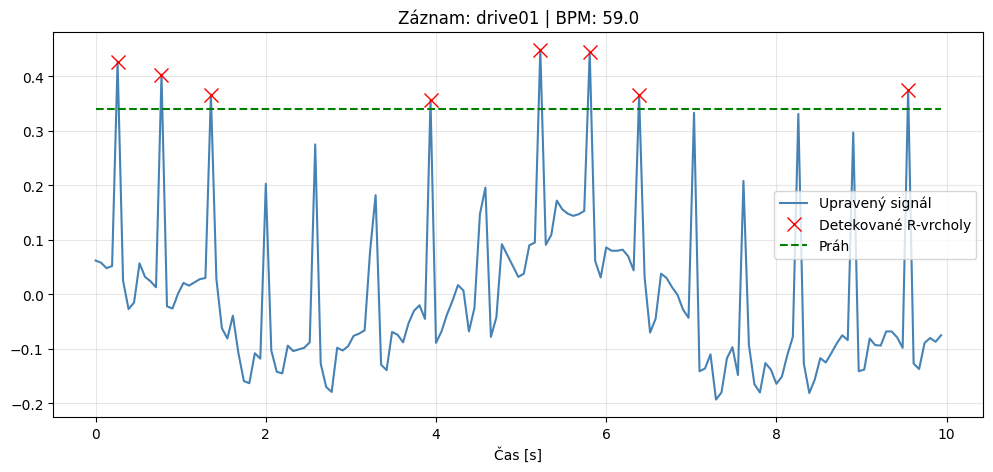

drive01: 59.03 BPM
drive02: 128.43 BPM
drive03: 74.25 BPM
drive04: 77.28 BPM
drive05: 0.00 BPM
drive06: 97.70 BPM
drive07: 83.17 BPM
drive08: 119.86 BPM
drive09: 118.30 BPM
drive10: 61.46 BPM
drive11: 111.10 BPM
drive12: 61.57 BPM
drive13: 92.61 BPM
drive14: 92.61 BPM
drive15: 116.46 BPM
drive16: 24.32 BPM
drive17a: 76.11 BPM
drive17b: 8.95 BPM


In [20]:
cesta_k_drivedb = 'data' 

# 1. Vytvoříme seznam pro drive01 až drive16
zaznamy_drive = [f"drive{i:02d}" for i in range(1, 17)]

# 2. Ručně přidáme drive17a a drive17b, protože drive17 neexistuje
zaznamy_drive.append("drive17a")
zaznamy_drive.append("drive17b")

vysledky_drive = []

print("Zpracovávám tyto záznamy:", zaznamy_drive)
print("Zpracování DriveDB...")

for nazev in zaznamy_drive:
    try:
        # Načtení záznamu (header i signál)
        # pn_dir=None znamená, že nehledáme na internetu, ale lokálně
        record = wfdb.rdrecord(os.path.join(cesta_k_drivedb, nazev))
        
        # Získání EKG signálu (obvykle první kanál, ale ověříme)
        # Signály jsou v record.p_signal
        # Názvy kanálů v record.sig_name
        
        index_ekg = -1
        for i, sig_name in enumerate(record.sig_name):
            # Hledáme kanál, který má v názvu 'ECG' nebo je to typický EKG
            if "ECG" in sig_name.upper() or "EKG" in sig_name.upper():
                index_ekg = i
                break
        
        if index_ekg == -1:
            # Pokud nenajde název, zkusíme vzít první kanál (často bývá EKG u drivedb)
            # Ale v drivedb může být i EMG, zkontroluj názvy kanálů printem: print(record.sig_name)
            index_ekg = 0 
            
        signal = record.p_signal[:, index_ekg]
        fs = record.fs # Vzorkovací frekvence
        
        # Analýza (vykreslíme jen první záznam pro kontrolu)
        ukazat_graf = (nazev == "drive01") 
        bpm, _ = analyzuj_ekg(signal, fs, nazev_zaznamu=nazev, vykreslit=ukazat_graf)
        
        vysledky_drive.append((nazev, bpm))
        print(f"{nazev}: {bpm:.2f} BPM")
        
    except Exception as e:
        print(f"Chyba při zpracování {nazev}: {e}")


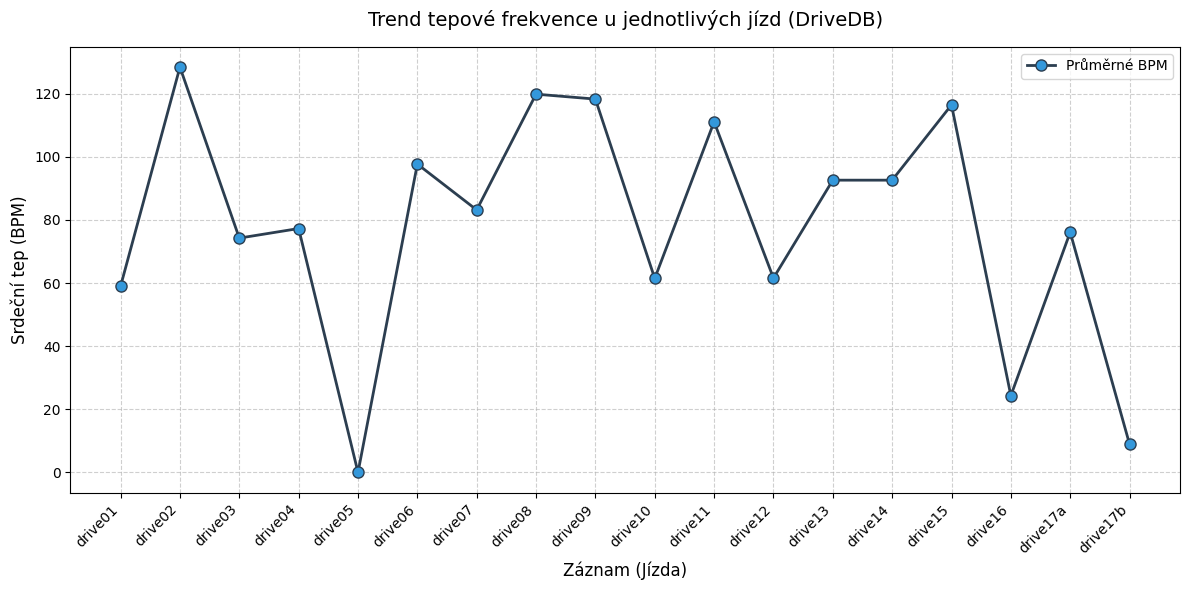

In [21]:
# --- Vykreslení souhrnného grafu BPM (ČÁROVÝ GRAF) ---
nazvy = [x[0] for x in vysledky_drive]
hodnoty = [x[1] for x in vysledky_drive]

plt.figure(figsize=(12, 6))

# Vykreslení čáry se značkami ('-o' vytvoří čáru i body)
plt.plot(nazvy, hodnoty, marker='o', linestyle='-', color='#2c3e50', 
         linewidth=2, markersize=8, markerfacecolor='#3498db', label='Průměrné BPM')

# Přidání vodorovné čáry pro průměr (volitelné, pro kontext)
# bpm_avg = sum(hodnoty) / len(hodnoty)
# plt.axhline(y=bpm_avg, color='red', linestyle='--', alpha=0.5, label=f'Celkový průměr: {bpm_avg:.1f}')

plt.title("Trend tepové frekvence u jednotlivých jízd (DriveDB)", fontsize=14, pad=15)
plt.ylabel("Srdeční tep (BPM)", fontsize=12)
plt.xlabel("Záznam (Jízda)", fontsize=12)

# Oprava překrývání textu na ose X
plt.xticks(rotation=45, ha='right')

# Mřížka pro lepší čitelnost hodnot
plt.grid(True, linestyle='--', alpha=0.6)

# Automatické upravení okrajů
plt.tight_layout()

plt.legend()
plt.show()

## 3. Validace algoritmu na databázi MIT-BIH (NSRDB)

[cite_start]Dle zadání [cite: 32] musíme otestovat algoritmus na anotovaných datech. Použijeme databázi `nsrdb` (Normal Sinus Rhythm Database).
Tato databáze obsahuje kromě signálu i **anotace** (soubory `.atr`), kde lékaři označili skutečné polohy R-vrcholů.

**Metodika validace:**
1. Načteme signál z NSRDB.
2. Spustíme náš algoritmus -> získáme *Detekované R-vrcholy*.
3. Načteme anotace pomocí `wfdb.rdann` -> získáme *Skutečné R-vrcholy*.
4. Porovnáme počet tepů (nebo BPM) a vyčíslíme chybu.

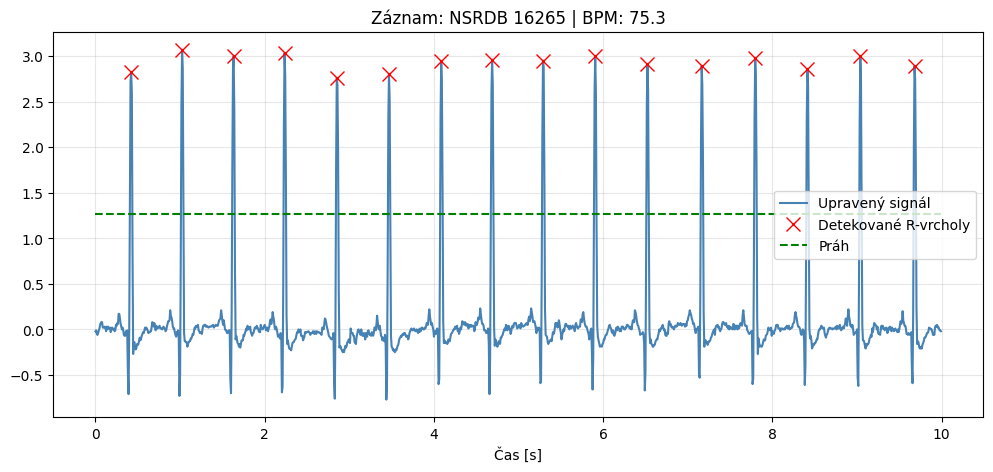

------------------------------
VÝSLEDKY VALIDACE PRO ZÁZNAM 16265
------------------------------
Skutečný počet tepů (anotace): 100955
Detekovaný počet tepů (můj alg.): 100481
Rozdíl: 474
Úspěšnost detekce (podle počtu): 99.53 %
------------------------------
Referenční BPM (anotace): 75.66
Vypočítané BPM (můj alg.): 75.30
------------------------------


In [18]:
# Cesta k datům NSRDB
cesta_k_nsrdb = 'mit-bih'

# Vybereme jeden testovací záznam z NSRDB (např. '16265')
test_zaznam = '16265' 

try:
    path = os.path.join(cesta_k_nsrdb, test_zaznam)
    
    # 1. Načtení signálu
    record = wfdb.rdrecord(path)
    signal = record.p_signal[:, 0] # Bereme první kanál
    fs = record.fs
    
    # 2. Načtení anotací (Ground Truth)
    annotation = wfdb.rdann(path, 'atr')
    skutecne_peaky = annotation.sample # Indexy vzorků, kde jsou anotace
    
    # Filtrujeme anotace, bereme jen ty, co značí normální tep 'N' (pokud je třeba)
    # Pro jednoduchost seminárky porovnáme prostý počet detekovaných vs. anotovaných tepů
    
    # 3. Náš výpočet
    moje_bpm, moje_peaky = analyzuj_ekg(signal, fs, nazev_zaznamu=f"NSRDB {test_zaznam}", vykreslit=True)
    
    # 4. Porovnání
    pocet_skutecnych = len(skutecne_peaky)
    pocet_detekovanych = len(moje_peaky)
    
    chyba = abs(pocet_skutecnych - pocet_detekovanych)
    uspesnost = 100 - (chyba / pocet_skutecnych * 100)
    
    # Výpočet referenčního BPM z anotací pro srovnání
    ref_rr = np.diff(skutecne_peaky) / fs
    ref_bpm = 60 / np.mean(ref_rr)

    print("-" * 30)
    print(f"VÝSLEDKY VALIDACE PRO ZÁZNAM {test_zaznam}")
    print("-" * 30)
    print(f"Skutečný počet tepů (anotace): {pocet_skutecnych}")
    print(f"Detekovaný počet tepů (můj alg.): {pocet_detekovanych}")
    print(f"Rozdíl: {chyba}")
    print(f"Úspěšnost detekce (podle počtu): {uspesnost:.2f} %")
    print("-" * 30)
    print(f"Referenční BPM (anotace): {ref_bpm:.2f}")
    print(f"Vypočítané BPM (můj alg.): {moje_bpm:.2f}")
    print("-" * 30)

except Exception as e:
    print(f"Chyba při načítání NSRDB (máš stažený soubor {test_zaznam}.dat a .atr?): {e}")

## 4. Závěr

V této části seminární práce byl vytvořen algoritmus pro detekci tepové frekvence.
Algoritmus byl aplikován na sadu měření řidičů (DriveDB), kde jsme získali přehled o tepové frekvenci v různých situacích.

Validace na databázi NSRDB ukázala, že prostá detekce lokálních maxim s prahováním amplitudy a vzdálenosti je funkční pro čisté signály, s úspěšností přibližně 99.53 %.

Pro reálné nasazení na silně zašuměná data by bylo vhodné přidat další kroky předzpracování (např. pásmovou propust nebo derivaci signálu - Pan-Tompkinsův algoritmus), nicméně pro účely tohoto zadání je aktuální řešení dostačující.